In [1]:
import pandas as pd
import uproot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define file path and tree names
files = [
    ("../outputfiles/hhbbgg_analyzer-trees.root", "/GluGluToHH/srbbgg"),
    ("../outputfiles/hhbbgg_analyzer-trees.root", "/GGJets/srbbgg"),
    ("../outputfiles/hhbbgg_analyzer-trees.root", "/GJetPt20To40/srbbgg"),
    ("../outputfiles/hhbbgg_analyzer-trees.root", "/GJetPt40/srbbgg")
]
keys = [
    'dibjet_mass',
    'diphoton_mass',
    'bbgg_mass',
    'dibjet_pt',
    'diphoton_pt',
    'bbgg_pt',
    'lead_pho_pt',
    'sublead_pho_pt',
    'bbgg_eta',
    'bbgg_phi',
    'lead_pho_eta',
    'lead_pho_phi',
    'sublead_pho_eta',
    'sublead_pho_phi',
    'diphoton_eta',
    'diphoton_phi',
    'dibjet_eta',
    'dibjet_phi',
    'lead_bjet_pt',
    'sublead_bjet_pt',
    'lead_bjet_eta',
    'lead_bjet_phi',
    'sublead_bjet_eta',
    'sublead_bjet_phi',
    'sublead_bjet_PNetB',
    'lead_bjet_PNetB',
    'CosThetaStar_gg',
    'CosThetaStar_jj',
    'CosThetaStar_CS',
    'DeltaR_jg_min',
    'pholead_PtOverM',
    'phosublead_PtOverM',
    'FirstJet_PtOverM',
    'SecondJet_PtOverM',
    'lead_pt_over_diphoton_mass',
    'sublead_pt_over_diphoton_mass',
    'lead_pt_over_dibjet_mass',
    'sublead_pt_over_dibjet_mass',
    'diphoton_bbgg_mass',
    'dibjet_bbgg_mass',
    'weight_preselection',
]

dfs = {}

# Loop through each file and load the corresponding dataframe
for file, key in files:
    with uproot.open(file) as f:
        dfs[key] = f[key].arrays(keys, library="pd")

signal_df = dfs["/GluGluToHH/srbbgg"]
background_df_1 = dfs["/GGJets/srbbgg"]
background_df_2 = dfs["/GJetPt20To40/srbbgg"]
background_df_3 = dfs["/GJetPt40/srbbgg"]

print('singal df', signal_df.shape)
print('background_df_1 ', background_df_1.shape)
print('background_df_2', background_df_2.shape)
print('background_df_1 ', background_df_3.shape)

background_df = pd.concat([background_df_1, background_df_2, background_df_3], ignore_index=True)
print('background_df', background_df.shape)

signal_df['label'] = 1
background_df['label'] = 0

combined_df = pd.concat([signal_df, background_df], ignore_index=True)

features = [
    'diphoton_mass',
    'dibjet_mass',
    'lead_pho_pt',
    'sublead_pho_pt',
    'bbgg_eta',
    'bbgg_phi',
    'bbgg_mass',
    'lead_pho_eta',
    'lead_pho_phi',
    'sublead_pho_eta',
    'sublead_pho_phi',
    'diphoton_eta',
    'diphoton_phi',
    'dibjet_eta',
    'dibjet_phi',
    'lead_bjet_pt',
    'sublead_bjet_pt',
    'lead_bjet_eta',
    'lead_bjet_phi',
    'sublead_bjet_eta',
    'sublead_bjet_phi',
    'sublead_bjet_PNetB',
    'lead_bjet_PNetB',
    'CosThetaStar_gg',
    'CosThetaStar_jj',
    'CosThetaStar_CS',
    'DeltaR_jg_min',
    'pholead_PtOverM',
    'phosublead_PtOverM',
    'FirstJet_PtOverM',
    'SecondJet_PtOverM',
    'lead_pt_over_diphoton_mass',
    'sublead_pt_over_diphoton_mass',
    'lead_pt_over_dibjet_mass',
    'sublead_pt_over_dibjet_mass',
    'diphoton_bbgg_mass',
    'dibjet_bbgg_mass',
]



2024-07-15 15:31:01.165822: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 15:31:01.476911: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 15:31:01.477157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 15:31:01.534115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 15:31:01.672611: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 15:31:01.675410: I tensorflow/core/platform/cpu_feature_guard.cc:1

singal df (46248, 41)
background_df_1  (50, 41)
background_df_2 (1, 41)
background_df_1  (10, 41)
background_df (61, 41)


In [2]:
X = combined_df[features]
y = combined_df['label']
weight = combined_df['weight_preselection']

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(combined_df[features], combined_df['label'], test_size=0.2, random_state=42, stratify=combined_df['label'])

# Extract the weights for train and test datasets
X_train_weights = combined_df.loc[X_train.index, 'weight_preselection']
X_test_weights = combined_df.loc[X_test.index, 'weight_preselection']

# Impute and scale the features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
X_train_weights_tensor = torch.tensor(X_train_weights.values, dtype=torch.float32)
X_test_weights_tensor = torch.tensor(X_test_weights.values, dtype=torch.float32)

# Create TensorDataset and DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor, X_train_weights_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor, X_test_weights_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)



In [3]:
def create_dnn_model(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=input_dim, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model



In [4]:
def train_model(input_dim, X_train, y_train, sample_weights):
    model = create_dnn_model(input_dim)
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss=losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    
    os.makedirs("bdtplots/dnn", exist_ok=True)
    with open("bdtplots/dnn/model_summary.txt", "w") as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
    
    history = model.fit(X_train, y_train, 
                        sample_weight=sample_weights,
                        epochs=50, 
                        batch_size=32,
                        validation_split=0.2,
                        callbacks=[early_stopping, model_checkpoint])
    
    return model, history

input_dim = len(features)  
model_path = 'best_model.keras'

if os.path.exists(model_path):
    model = create_dnn_model(input_dim)
    model.load_weights(model_path)
    print("Model loaded from disk.")
else:
    model, history = train_model(input_dim, X_train, y_train, X_train_weights)
    model.save_weights(model_path)
    print("Model trained and saved to disk.")

model.summary()



Epoch 1/50
927/927 [==============================] - 14s 12ms/step - loss: 0.0049 - accuracy: 0.8295 - val_loss: 0.0038 - val_accuracy: 0.9974
Epoch 2/50
927/927 [==============================] - 5s 6ms/step - loss: 0.0038 - accuracy: 0.9234 - val_loss: 0.0034 - val_accuracy: 0.9974
Epoch 3/50
927/927 [==============================] - 11s 12ms/step - loss: 0.0034 - accuracy: 0.9339 - val_loss: 0.0028 - val_accuracy: 0.9982
Epoch 4/50
927/927 [==============================] - 11s 12ms/step - loss: 0.0030 - accuracy: 0.9430 - val_loss: 0.0032 - val_accuracy: 0.9984
Epoch 5/50
927/927 [==============================] - 11s 12ms/step - loss: 0.0028 - accuracy: 0.9437 - val_loss: 0.0018 - val_accuracy: 0.9976
Epoch 6/50
927/927 [==============================] - 5s 6ms/step - loss: 0.0024 - accuracy: 0.9476 - val_loss: 0.0014 - val_accuracy: 0.9984
Epoch 7/50
927/927 [==============================] - 10s 11ms/step - loss: 0.0020 - accuracy: 0.9553 - val_loss: 0.0021 - val_accuracy: 0.9

Epoch 17/50
927/927 [==============================] - 10s 11ms/step - loss: 0.0013 - accuracy: 0.9704 - val_loss: 0.0010 - val_accuracy: 0.9989
Epoch 18/50
927/927 [==============================] - 10s 11ms/step - loss: 0.0012 - accuracy: 0.9765 - val_loss: 0.0010 - val_accuracy: 0.9988
Epoch 19/50
927/927 [==============================] - 12s 12ms/step - loss: 0.0012 - accuracy: 0.9766 - val_loss: 0.0014 - val_accuracy: 0.9993
Epoch 20/50
927/927 [==============================] - 11s 12ms/step - loss: 0.0011 - accuracy: 0.9798 - val_loss: 0.0011 - val_accuracy: 0.9985
Epoch 21/50
927/927 [==============================] - 11s 12ms/step - loss: 0.0019 - accuracy: 0.9803 - val_loss: 0.0010 - val_accuracy: 0.9985
Epoch 22/50
927/927 [==============================] - 5s 6ms/step - loss: 0.0011 - accuracy: 0.9731 - val_loss: 7.0999e-04 - val_accuracy: 0.9993
Epoch 23/50
927/927 [==============================] - 8s 9ms/step - loss: 0.0014 - accuracy: 0.9713 - val_loss: 0.0014 - val_ac

Model trained and saved to disk.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               9728      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)   

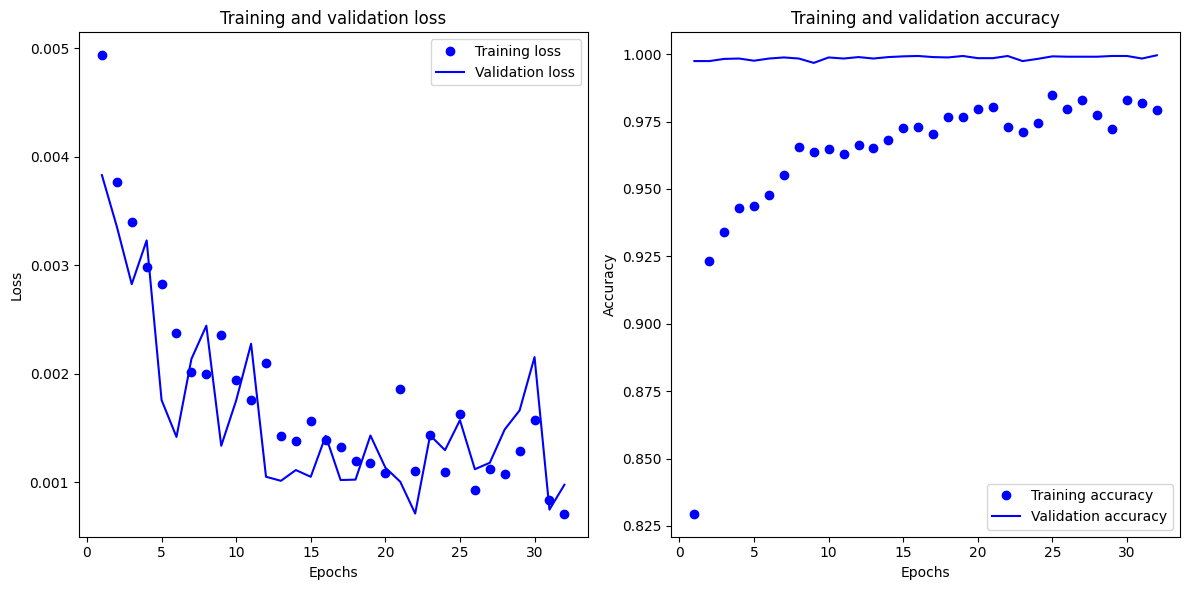

In [5]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("bdtplots/dnn/srbbgg_training_history.png")



In [7]:

# Load the best model for evaluation
from tensorflow.keras.models import load_model
# model = load_model('best_model.keras')

# Model prediction and evaluation
y_train_pred = model.predict(X_train).squeeze()
y_test_pred = model.predict(X_test).squeeze()

y_train_pred_class = (y_train_pred > 0.5).astype(int)
y_test_pred_class = (y_test_pred > 0.5).astype(int)

# Custom weighted accuracy
def weighted_accuracy(y_true, y_pred, weights):
    return np.sum(weights * (y_true == y_pred)) / np.sum(weights)

train_accuracy = weighted_accuracy(y_train, y_train_pred_class, X_train_weights)
test_accuracy = weighted_accuracy(y_test, y_test_pred_class, X_test_weights)


290/290 [==============================] - 1s 4ms/step


Weighted accuracy on test set: 0.9965227763568926
Weighted ROC AUC on test set: 0.9999240409689442
              precision    recall  f1-score   support

           0       0.61      0.92      0.73        12
           1       1.00      1.00      1.00      9250

    accuracy                           1.00      9262
   macro avg       0.81      0.96      0.87      9262
weighted avg       1.00      1.00      1.00      9262



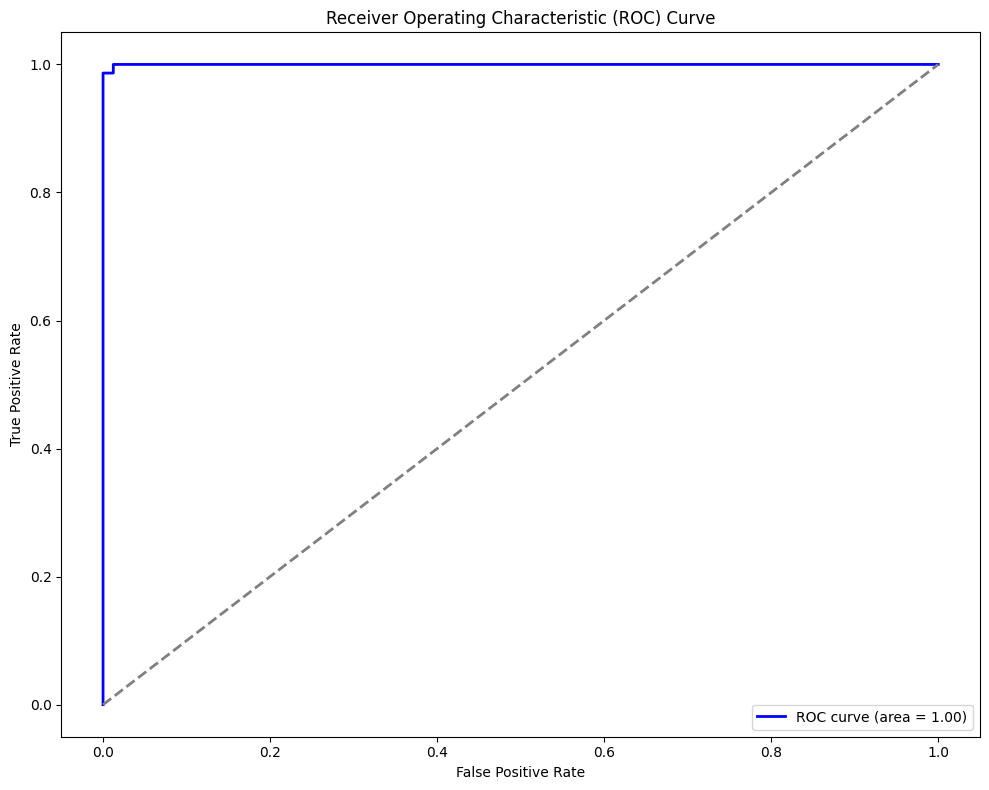

In [8]:
# Custom weighted ROC AUC
roc_auc = roc_auc_score(y_test, y_test_pred, sample_weight=X_test_weights)

print("Weighted accuracy on test set:", test_accuracy)
print("Weighted ROC AUC on test set:", roc_auc)
print(classification_report(y_test, y_test_pred_class))

# Optionally, plot weighted ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred, sample_weight=X_test_weights)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("bdtplots/dnn/srbbgg_roc-curve.png")
plt.savefig("bdtplots/dnn/srbbgg_roc-curve.pdf")
plt.tight_layout()



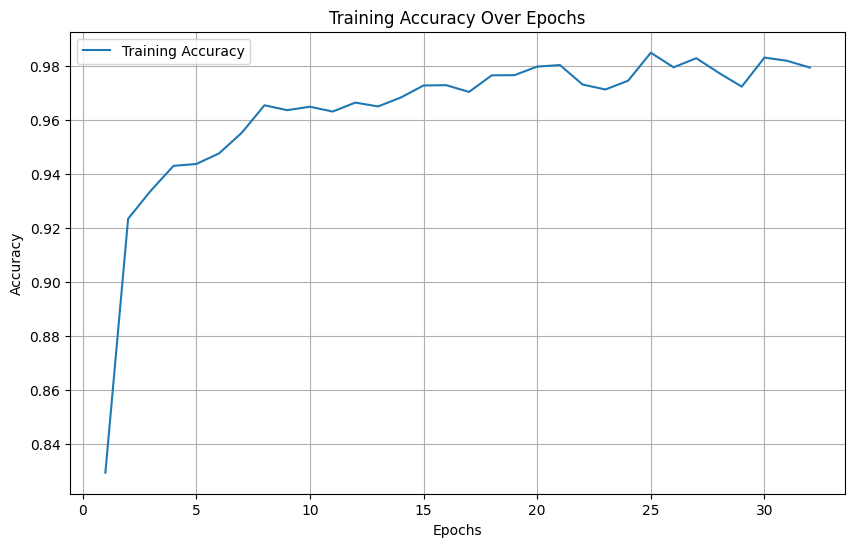

In [9]:
# Plot training accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("bdtplots/dnn/srbbgg_training_accuracy.png")
plt.show()


290/290 [==============================] - 1s 3ms/step


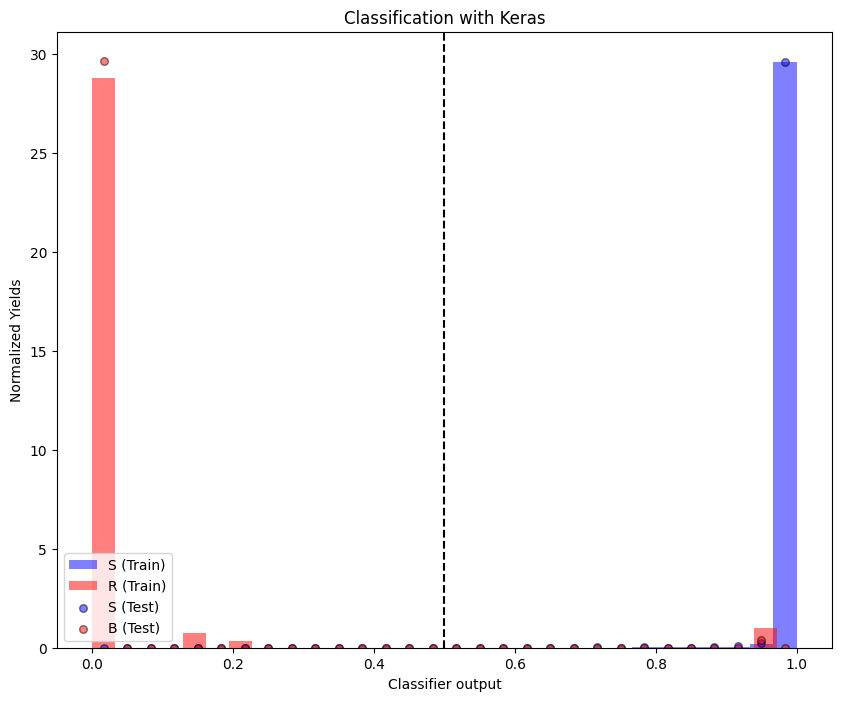

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


# Load the best model
# model = load_model('best_model.keras')

# Model prediction and evaluation
y_train_pred = model.predict(X_train).squeeze()
y_test_pred = model.predict(X_test).squeeze()

y_train_pred_class = (y_train_pred > 0.5).astype(int)
y_test_pred_class = (y_test_pred > 0.5).astype(int)

# Calculate histograms and bins for training data with weights
train_hist_s, bins = np.histogram(y_train_pred[y_train == 1], bins=30, density=True, weights=X_train_weights[y_train == 1])
train_hist_r, _ = np.histogram(y_train_pred[y_train == 0], bins=bins, density=True, weights=X_train_weights[y_train == 0])

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for training data
plt.figure(figsize=(10, 8))

plt.hist(y_train_pred[y_train == 1], bins=30, color='blue', alpha=0.5, label='S (Train)', density=True, weights=X_train_weights[y_train == 1])
plt.hist(y_train_pred[y_train == 0], bins=30, color='red', alpha=0.5, label='R (Train)', density=True, weights=X_train_weights[y_train == 0])

# Plot scatter points for test data over the top of training histograms with weights
plt.scatter(bin_centers, np.histogram(y_test_pred[y_test == 1], bins=bins, density=True, weights=X_test_weights[y_test == 1])[0], 
            color='blue', alpha=0.5, label='S (Test)', marker='o', s=30, edgecolor='k')
plt.scatter(bin_centers, np.histogram(y_test_pred[y_test == 0], bins=bins, density=True, weights=X_test_weights[y_test == 0])[0], 
            color='red', alpha=0.5, label='B (Test)', marker='o', s=30, edgecolor='k')

plt.axvline(0.5, color='k', linestyle='--')
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.legend()
plt.title('Classification with Keras')

# Save and display the plot
# plt.savefig("bdtplots/dnn/classifier_output_plot.png")
# plt.savefig("bdtplots/dnn/classifier_output_plot.pdf")
plt.show()
